In [1]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[  starty:starty + new_height, startx:startx + new_width, :]


In [2]:
import torch
from torch.utils.data import Dataset,DataLoader 
import numpy as np
import h5py
import matplotlib.pyplot as plt

class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = np.array(self.dataset[str(index)+'.jpg'])
        # 128x128 사각형으로 크롭
        img = crop_centre(img, 128, 128)
        return torch.FloatTensor(img).permute(2,0,1).view(3,128,128) / 255.0
    
    def plot_image(self, index):
        img = np.array(self.dataset[str(index)+'.jpg'])
        # 128x128 사각형으로 크롭
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass
    

In [3]:
import torch
import torch.nn as nn

class View(nn.Module):
    def __init__(self,shape):
        super().__init__()
        self.shape = shape,
    def forward(self,x):
        return x.view(*self.shape)

In [4]:
class ConvVAE(nn.Module):
    def __init__(self,dim_latent=200):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        self.dim_latent = dim_latent
       # 신경망 레이어 정의
        self.encoder = nn.Sequential(
            # (1,3,128,128) 형태를 의도
            nn.Conv2d(3, 32, kernel_size=7, stride=2,padding=3),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(1,32,64,64)
            
            nn.Conv2d(32, 64, kernel_size=7, stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(1,64,32,32)

            nn.Conv2d(64, 64, kernel_size=5, stride=2,padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(1,64,16,16)
            
            nn.Conv2d(64, 64, kernel_size=3, stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(1,64,8,8)

            View((-1,64*8*8)),
            nn.Linear(64*8*8, 2*self.dim_latent),
        )
        
        self.decoder = nn.Sequential(
            #(200)
            nn.Linear(self.dim_latent,64*8*8),
            View((-1,64,8,8)),
            #(64,8,8)

            nn.ConvTranspose2d(64,64,4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),            
            #(64,16,16)

            nn.ConvTranspose2d(64,64,6,stride=2,padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            #(64,32,32)

            nn.ConvTranspose2d(64,32,8,stride=2,padding=3),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            #(32,64,64)

            nn.ConvTranspose2d(32,3,8,stride=2,padding=3),
            nn.Sigmoid()
            #(3,128,128)
        )

        # 손실 함수 생성
        self.loss_function = nn.BCELoss()

        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0005)
    def forward(self,x):
        x = self.encoder(x)
        print(x.shape)
        x = x.view(-1,2,self.dim_latent)

        self.mu = x[:,0,:]
        self.log_var = x[:,1,:]
        print(self.mu.shape)
        print(self.log_var.shape)

        epsilon = torch.randn_like(self.mu)
        sigma = torch.exp(self.log_var/2)

        self.z = self.mu+sigma*epsilon
        de = self.decoder(self.z)
        return de

    def train(self,data_loader):
        kl_loss_wight=10000
        for epoch in range(1, 101):
            for x_input in data_loader:
                self.optimiser.zero_grad()
                print(x_input.shape)
                y_pred = self.forward(x_input)
                
                mse_loss = ((y_pred- x_input)**2).sum()
                kl_loss = -0.5*torch.sum(1+self.log_var-2*self.mu**2 - 2*torch.exp(self.log_var))
                loss = mse_loss+kl_loss*kl_loss_wight
                loss.backward()
                self.optimiser.step()
            if epoch % 1 == 0:
                print(f"Epoch {epoch}: loss = {loss.item()} mse loss= {mse_loss:.2f} kl loss={kl_loss*kl_loss_wight:.2f}")


In [5]:
x_input = torch.FloatTensor(torch.randn((1,3,128,128)))
convVAE_hongver = ConvVAE()
myconvVAE = ConvVAE()

In [6]:
convVAE_hongver.load_state_dict(torch.load("my_vae_celeb_re_trained_hongver.pth",map_location=torch.device('cpu')))
myconvVAE.load_state_dict(torch.load("my_vae_celeb_re_trained.pth",map_location=torch.device('cpu')))


<All keys matched successfully>

In [7]:
dataloader = DataLoader(CelebADataset('./data/celeba_aligned_small.h5py'),100)

In [8]:

for data in dataloader:
    myconvVAE.forward(data)
    print(myconvVAE.z.shape)
    break


torch.Size([100, 400])
torch.Size([100, 200])
torch.Size([100, 200])
torch.Size([100, 200])


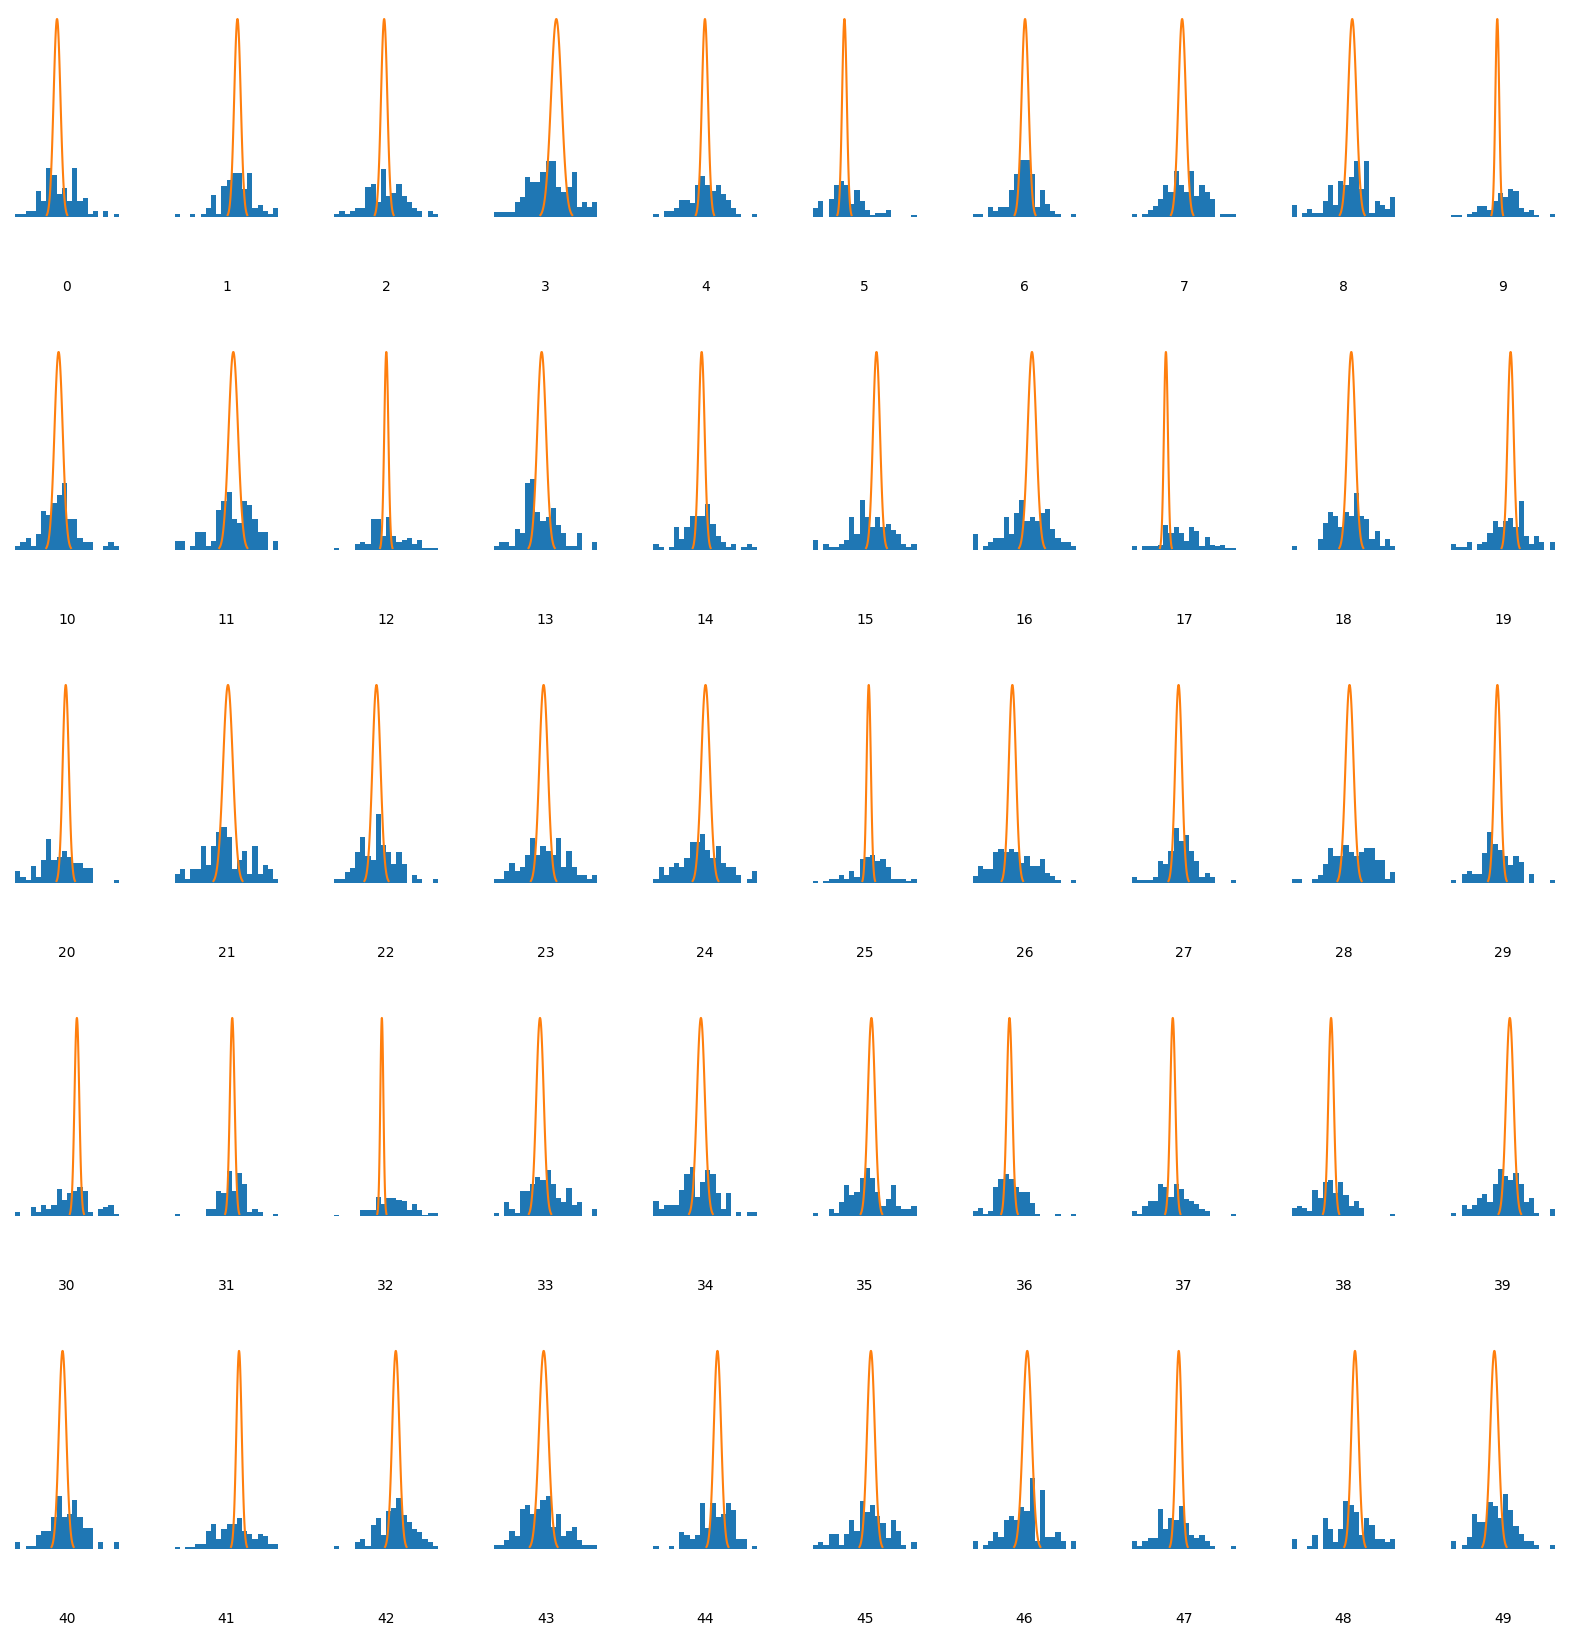

In [11]:
from scipy.stats import norm

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(myconvVAE.z.detach().numpy()[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

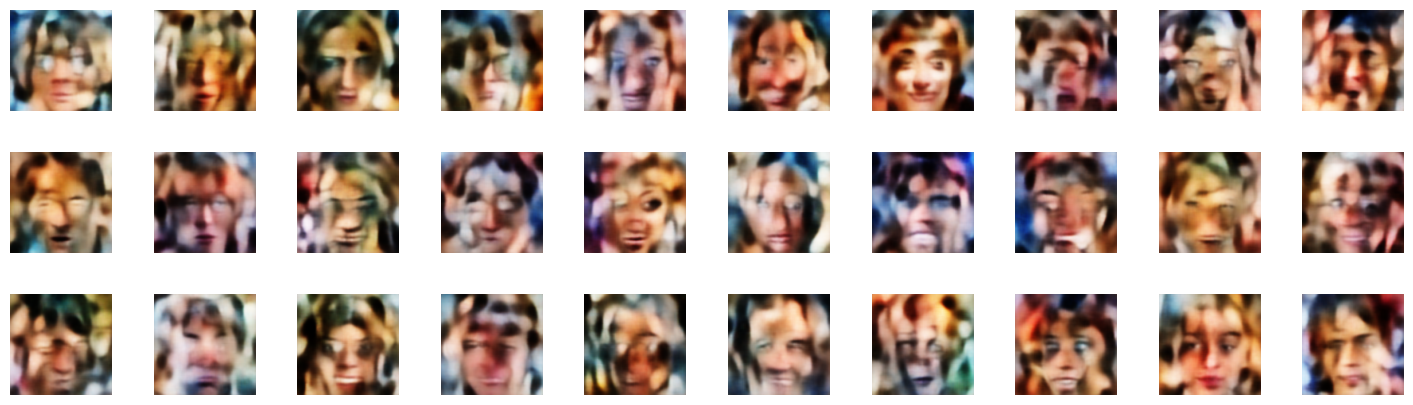

In [22]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,200))

reconst = myconvVAE.decoder.forward(torch.FloatTensor(znew)).detach().numpy().transpose((0,2,3,1))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [13]:
for data in dataloader:
    convVAE_hongver.forward(data)
    print(convVAE_hongver.z.shape)
    break

torch.Size([100, 400])
torch.Size([100, 200])
torch.Size([100, 200])
torch.Size([100, 200])


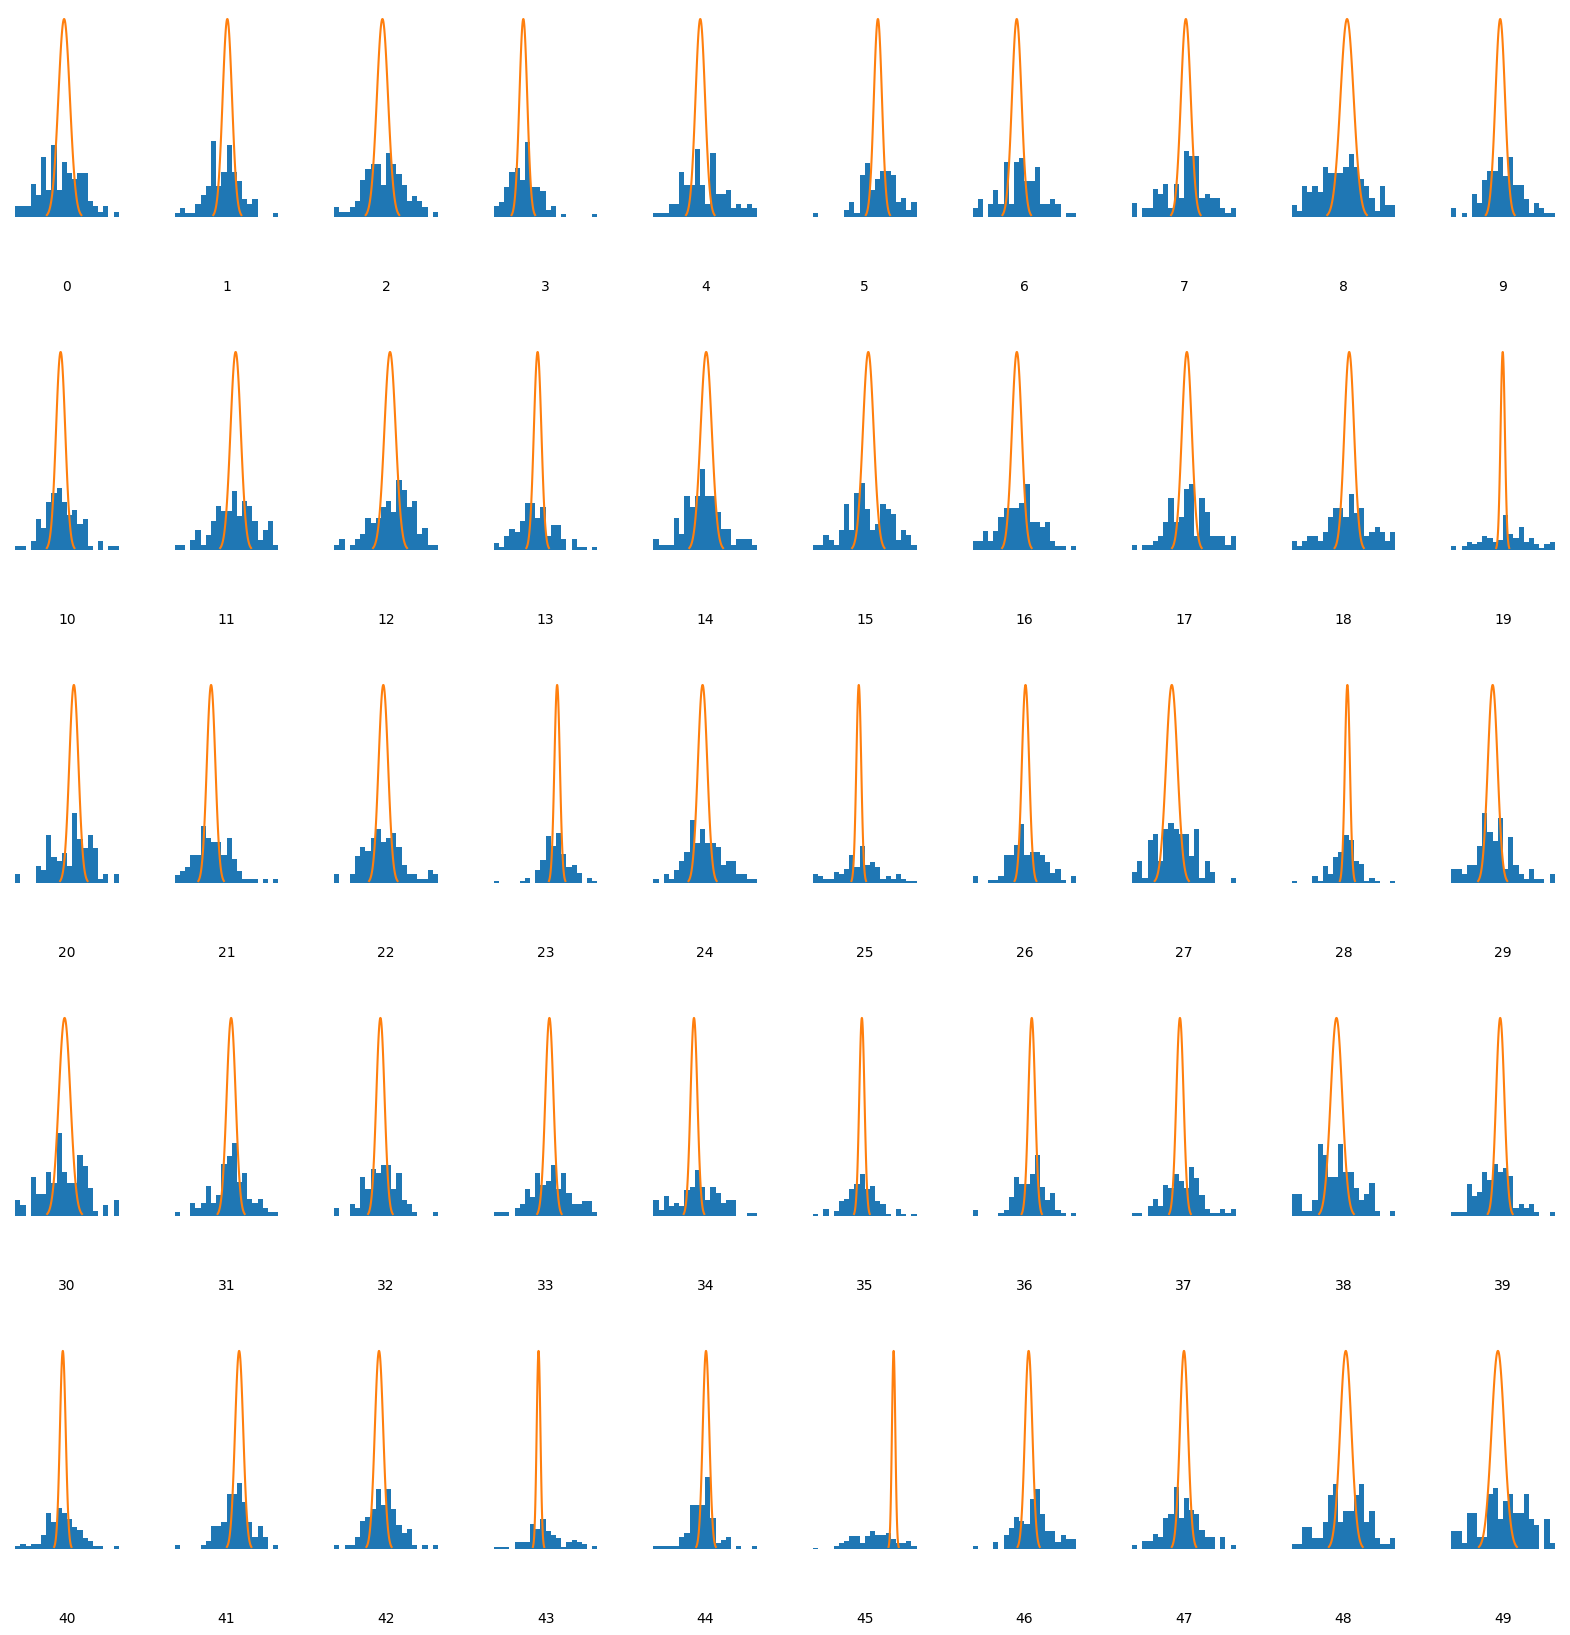

In [16]:
x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(convVAE_hongver.z.detach().numpy()[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

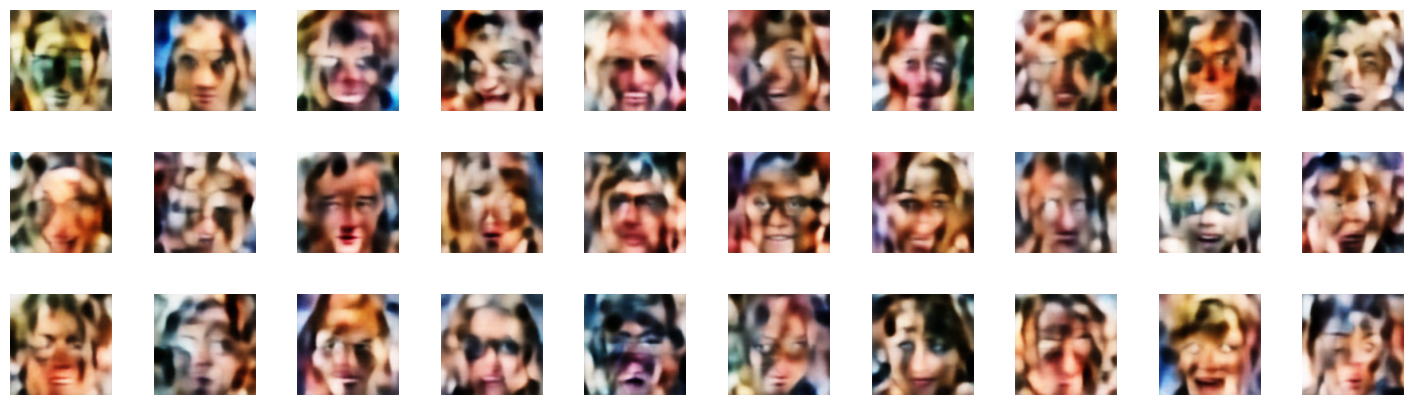

In [23]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,200))

reconst = convVAE_hongver.decoder.forward(torch.FloatTensor(znew)).detach().numpy().transpose((0,2,3,1))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()